In [2]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from data_utils.acdc_datamodule import ACDCDataModule


In [3]:

datamodule = ACDCDataModule("ACDC", 32,32,32,(256,256,1))

In [3]:

""" 
train dataset:
100 patients
2 gt + labeled frame / patient
28-40 total frame / patient

gt ~ 5kb
1frame ~ 500kb
whole frame ~15-25mb

only gt images: ~(500kb + 5kb) * 2 * 100= 101 mb
whole frames: ~ 20mb * 100 = 2000mb


how to work with nifti images:
https://neuraldatascience.io/8-mri/nifti.html

about the dataset:
https://ieeexplore.ieee.org/document/8360453


Paper III.A.3 - Normalization:
"
In order for
challengers to normalize the physiological parameters
(mainly the LV and RV volumes and the MYO mass) with the body
surface area (BSA), the weight and height of each patient
are included in the dataset.

For instance, the BSA can be
calculated from the formula of Du Bois and Du Bois [40],
i.e. BSA = 0.007184 * (weight^0.425 * height^0.725) and normalized parameters can be computed by simply dividing their
values with the corresponding BSA.

"

Paper III.B - GT format:
"
The ground truth label images were stored in nifti format.
The label values vary from 0 to 3 and represent voxels
belonging to the background (0), the RV cavity (1), the
myocardium (2) and the LV cavity (3).

"

Evaluation metrics defined in Paper III.C section


Paper IV.A: baseline architectures for segmentation



 """

' \ntrain dataset:\n100 patients\n2 gt + labeled frame / patient\n28-40 total frame / patient\n\ngt ~ 5kb\n1frame ~ 500kb\nwhole frame ~15-25mb\n\nonly gt images: ~(500kb + 5kb) * 2 * 100= 101 mb\nwhole frames: ~ 20mb * 100 = 2000mb\n\n\nhow to work with nifti images:\nhttps://neuraldatascience.io/8-mri/nifti.html\n\nabout the dataset:\nhttps://ieeexplore.ieee.org/document/8360453\n\n\nPaper III.A.3 - Normalization:\n"\nIn order for\nchallengers to normalize the physiological parameters\n(mainly the LV and RV volumes and the MYO mass) with the body\nsurface area (BSA), the weight and height of each patient\nare included in the dataset.\n\nFor instance, the BSA can be\ncalculated from the formula of Du Bois and Du Bois [40],\ni.e. BSA = 0.007184 * (weight^0.425 * height^0.725) and normalized parameters can be computed by simply dividing their\nvalues with the corresponding BSA.\n\n"\n\nPaper III.B - GT format:\n"\nThe ground truth label images were stored in nifti format.\nThe label val

In [4]:
# 30 images, no ground_truth, maybe good for learning represetations
# ~15mb
# last dimension is the number of images
path = "patient001_4d.nii"
img = nib.load(path).get_fdata()
img.shape

(216, 256, 10, 30)

In [9]:
print(nib.load(path).header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 216 256  10  30   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [ 1.      1.5625  1.5625 10.      1.      1.      1.      1.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 614.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 1071
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : unknown
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x 

In [66]:
# zip called xy_gt_nii.gz is the ground_truth
#  ~ 6kb
path = "DCM03-OH-AL_V2_1.nii"
img2 = nib.load(path).get_fdata()
img2 = np.transpose(img2, (2,0,1) )

img2.shape

(10, 216, 256)

In [67]:
# frame with gt
# ~ 500kb
path = "patient001_frame01.nii\\CMD03Gate1.nii"
img3 = nib.load(path).get_fdata()
img3 = np.transpose(img3, (2,0,1) )

img3.shape

(10, 216, 256)

In [68]:
img3.max()

658.0

In [69]:
img3[:,:,0].max()

282.0

In [87]:
# split the multi-class masks into submasks
mask0 = np.where(img2[:,:] == 0, 1,0)
mask1 = np.where(img2[:,:] == 1, 1,0)
mask2 = np.where(img2[:,:] == 2, 1,0)
mask3 = np.where(img2[:,:] == 3, 1,0)
img3_0 = img3 * mask0
img3_1 = img3 * mask1
img3_2 = img3 * mask2
img3_3 = img3 * mask3
masked_images = [img3_0, img3_1, img3_2, img3_3]
masked_images[0].shape
masks = [mask0,mask1,mask2,mask3 ]


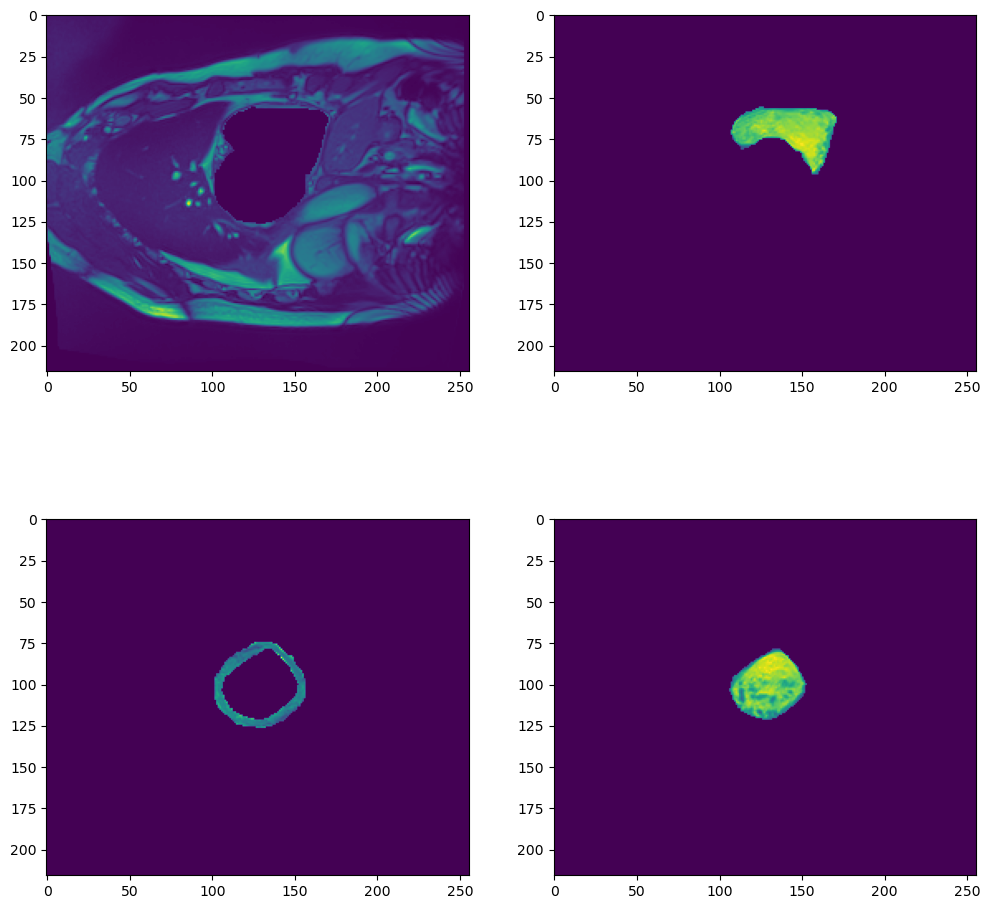

In [71]:
plt.style.use('default')
fig, axes = plt.subplots(2,2, figsize=(12,12))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(masked_images[i][1])
plt.show()

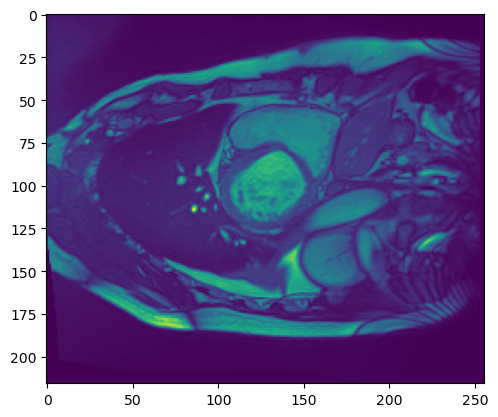

In [76]:
plt.imshow(img3[1])

In [73]:
def visualize(image_raw,mask):
    """
    iamge_raw:gray image with shape [width,height,1]
    mask: segment mask image with shape [num_class,width,height]
    this function return an image using multi color to visualize masks in raw image
    """
    # Convert grayscale image to RGB
    image = cv2.cvtColor(image_raw, cv2.COLOR_GRAY2RGB)
    
    # Get the number of classes (i.e. channels) in the mask
    num_class = mask.shape[0]
    
    # Define colors for each class (using a simple color map)
    colors = []
    for i in range(1, num_class):  # skip first class (background)
        hue = int(i/float(num_class-1) * 179)
        color = np.zeros((1, 1, 3), dtype=np.uint8)
        color[0, 0, 0] = hue
        color[0, 0, 1:] = 255
        color = cv2.cvtColor(color, cv2.COLOR_HSV2RGB)
        colors.append(color)

    # Overlay each non-background class mask with a different color on the original image
    for i in range(1, num_class):
        class_mask = mask[i, :, :]
        class_mask = np.repeat(class_mask[:, :, np.newaxis], 3, axis=2)
        class_mask = class_mask.astype(image.dtype)
        class_mask = class_mask * colors[i-1]
        image = cv2.addWeighted(image, 1.0, class_mask, 0.5, 0.0)

    return image

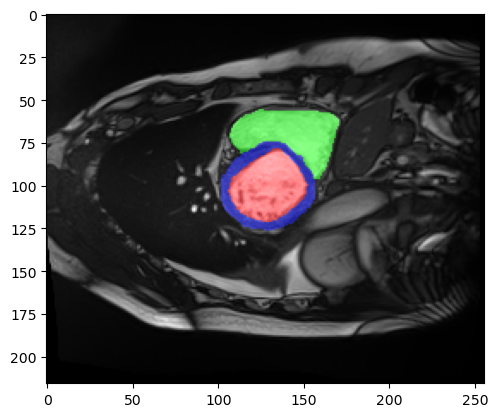

In [113]:
new_img = img3[1][:,:,None]
masks = np.array(masks)
masks = np.transpose(masks, (1,0,2,3))
normalized_image = cv2.normalize(img3[1], None, 0, 255, cv2.NORM_MINMAX)
normalized_image = normalized_image.astype(np.uint8)
vis_img = visualize(normalized_image, masks[1])

plt.imshow(vis_img)

In [109]:
normalized_image.astype(np.uint8).dtype

dtype('uint8')

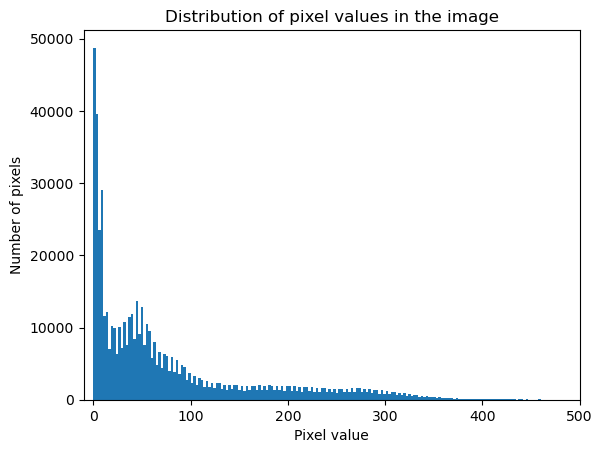

In [ ]:
plt.hist(img3.flatten(), bins=256)
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.title('Distribution of pixel values in the image')
plt.xlim(-10,500)
plt.show()

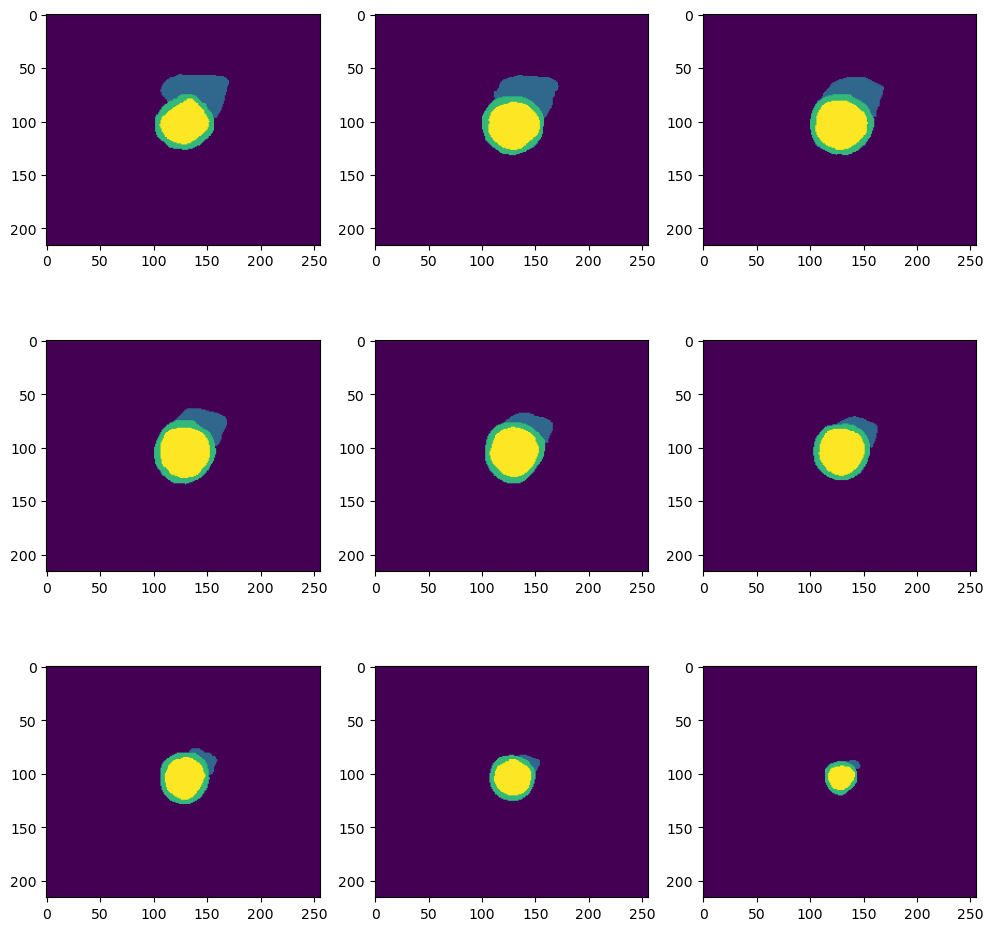

In [ ]:
plt.style.use('default')
fig, axes = plt.subplots(3,3, figsize=(12,12))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(img2[:,:,1 + i])
plt.show()

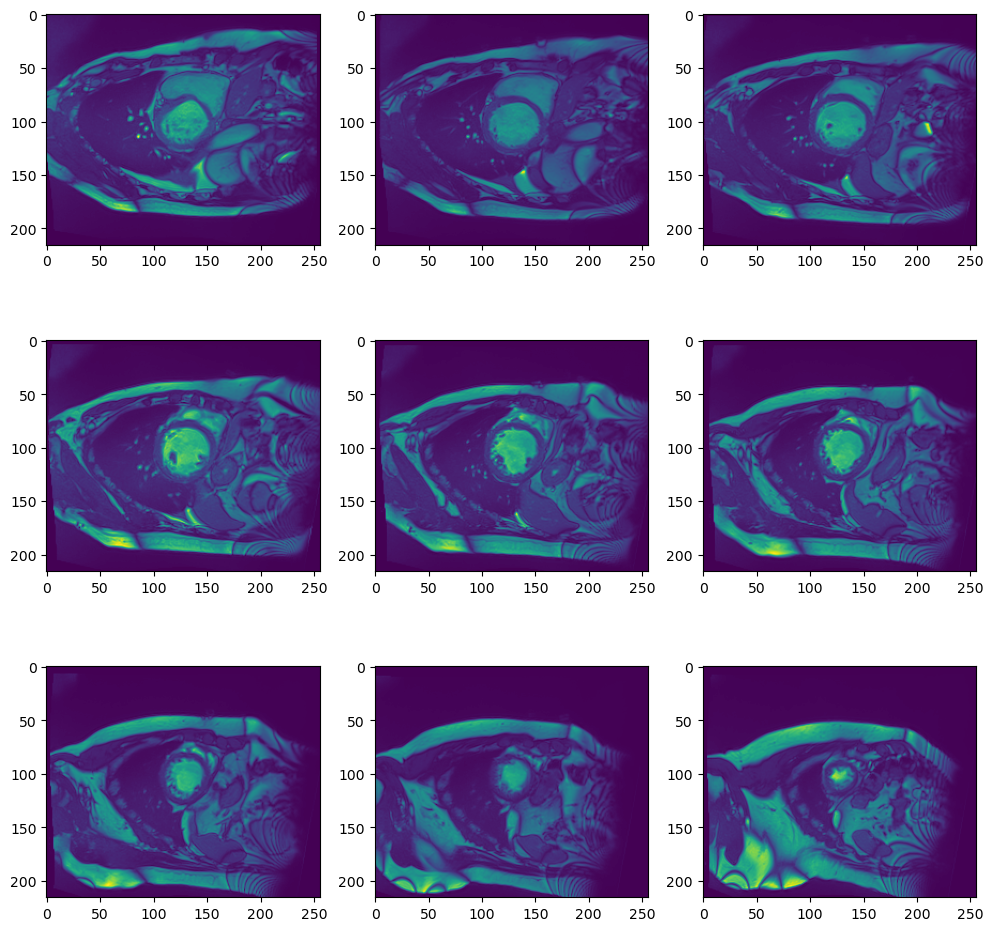

In [ ]:
plt.style.use('default')
fig, axes = plt.subplots(3,3, figsize=(12,12))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(img3[:,:,1 + i])
plt.show()